# Лабораторная работа №2
**Тема:** Реализация алгоритмов через MapReduce

**Задания:**

1. Построить алгоритм произведения матриц через MapReduce.  
2. Построить алгоритм линейной регрессии через MapReduce.  
3. Продемонстрировать их работу.


In [ ]:
from collections import defaultdict
from typing import Any, Iterable, List, Tuple, Callable


def run_map_reduce(
    records: Iterable[Any],
    mapper: Callable[[Any], Iterable[Tuple[Any, Any]]],
    reducer: Callable[[Any, List[Any]], Any],
) -> List[Tuple[Any, Any]]:

    # ---- MAP ----
    intermediate = []  # список (key, value)
    for record in records:
        for key, value in mapper(record):
            intermediate.append((key, value))

    # ---- SHUFFLE & SORT (группировка по ключу) ----
    grouped = defaultdict(list)
    for key, value in intermediate:
        grouped[key].append(value)

    # ---- REDUCE ----
    results = []
    for key, values in grouped.items():
        reduced_value = reducer(key, values)
        results.append((key, reduced_value))

    return results


In [ ]:
# Пример матриц для демонстрации
# A: 2x3, B: 3x2

A = [
    [1, 2, 3],   # строка 0
    [4, 5, 6]    # строка 1
]

B = [
    [7,  8],     # строка 0
    [9, 10],     # строка 1
    [11, 12]     # строка 2
]

n_rows_A = len(A)          # n
n_cols_A = len(A[0])       # m
n_rows_B = len(B)          # должно быть равно m
n_cols_B = len(B[0])       # p

assert n_cols_A == n_rows_B, "Размеры матриц не согласованы!"

# Преобразуем матрицы в список записей вида:
# ("A", i, j, value) и ("B", j, k, value)

matrix_records = []

# Записи для A
for i in range(n_rows_A):
    for j in range(n_cols_A):
        matrix_records.append(("A", i, j, A[i][j]))

# Записи для B
for j in range(n_rows_B):
    for k in range(n_cols_B):
        matrix_records.append(("B", j, k, B[j][k]))

matrix_records[:10]


[('A', 0, 0, 1),
 ('A', 0, 1, 2),
 ('A', 0, 2, 3),
 ('A', 1, 0, 4),
 ('A', 1, 1, 5),
 ('A', 1, 2, 6),
 ('B', 0, 0, 7),
 ('B', 0, 1, 8),
 ('B', 1, 0, 9),
 ('B', 1, 1, 10)]

In [ ]:
def matrix_multiply_mapper(record):
    """
    Mapper для произведения матриц.

    record: ("A", i, j, value) или ("B", j, k, value)

    Для каждого A[i, j]:
      для всех k от 0 до n_cols_B-1 выдаём:
        key = (i, k)
        value = ("A", j, A[i, j])

    Для каждого B[j, k]:
      для всех i от 0 до n_rows_A-1 выдаём:
        key = (i, k)
        value = ("B", j, B[j, k])
    """
    matrix_name, row, col, value = record

    if matrix_name == "A":
        i, j = row, col
        for k in range(n_cols_B):
            yield ((i, k), ("A", j, value))
    elif matrix_name == "B":
        j, k = row, col
        for i in range(n_rows_A):
            yield ((i, k), ("B", j, value))
    else:
        # на всякий случай
        return


def matrix_multiply_reducer(key, values):
    """
    Reducer для произведения матриц.

    key: (i, k) - индекс элемента матрицы C
    values: список ("A" или "B", j, value)

    Идея:
      - собираем словари A_values[j] и B_values[j]
      - считаем сумму по j: A_ij * B_jk
    """
    # key = (i, k)
    # values: [("A", j, a_ij), ("B", j, b_jk), ...]
    A_values = {}
    B_values = {}

    for tag, j, val in values:
        if tag == "A":
            A_values[j] = val
        elif tag == "B":
            B_values[j] = val

    # j пробегает от 0 до n_cols_A-1 (т.е. m-1)
    result = 0
    for j in range(n_cols_A):
        a_ij = A_values.get(j, 0)
        b_jk = B_values.get(j, 0)
        result += a_ij * b_jk

    return result


In [ ]:
# Запускаем MapReduce для произведения матриц A и B
mapred_result = run_map_reduce(matrix_records, matrix_multiply_mapper, matrix_multiply_reducer)

# mapred_result: список ((i, k), C_ik)
mapred_result_sorted = sorted(mapred_result, key=lambda item: (item[0][0], item[0][1]))
mapred_result_sorted


[((0, 0), 58), ((0, 1), 64), ((1, 0), 139), ((1, 1), 154)]

In [ ]:
# Восстанавливаем матрицу C размера n_rows_A x n_cols_B

C = [[0 for _ in range(n_cols_B)] for _ in range(n_rows_A)]

for (i, k), value in mapred_result_sorted:
    C[i][k] = value

print("Матрица A:")
for row in A:
    print(row)

print("\nМатрица B:")
for row in B:
    print(row)

print("\nМатрица C = A * B (через MapReduce):")
for row in C:
    print(row)

# Для проверки посчитаем "напрямую" в Python и сравним
C_direct = [
    [sum(A[i][t] * B[t][k] for t in range(n_cols_A)) for k in range(n_cols_B)]
    for i in range(n_rows_A)
]

print("\nМатрица C, посчитанная напрямую:")
for row in C_direct:
    print(row)

print("\nСовпадает ли результат MapReduce с прямым умножением?",
      C == C_direct)


Матрица A:
[1, 2, 3]
[4, 5, 6]

Матрица B:
[7, 8]
[9, 10]
[11, 12]

Матрица C = A * B (через MapReduce):
[58, 64]
[139, 154]

Матрица C, посчитанная напрямую:
[58, 64]
[139, 154]

Совпадает ли результат MapReduce с прямым умножением? True


In [ ]:
# Синтетический набор данных для простой линейной регрессии
# Моделируем зависимость y ≈ 2x + 1

data_points = [
    (0.0, 1.0),
    (1.0, 3.0),
    (2.0, 5.0),
    (3.0, 7.0),
    (4.0, 9.0),
    (5.0, 11.0),
]

data_points


[(0.0, 1.0), (1.0, 3.0), (2.0, 5.0), (3.0, 7.0), (4.0, 9.0), (5.0, 11.0)]

In [ ]:
def linreg_mapper(point):
    """
    Mapper для линейной регрессии.

    point: (x, y)

    Для каждой точки выдаём одну пару:
      key = "stats"
      value = (1, x, y, x^2, x*y)
    """
    x, y = point
    yield ("stats", (1.0, x, y, x * x, x * y))


def linreg_reducer(key, values):
    """
    Reducer для линейной регрессии.

    key: "stats"
    values: список кортежей (n_i, sum_x_i, sum_y_i, sum_x2_i, sum_xy_i)
    """
    # Суммируем по всем локальным значениям
    n_total = 0.0
    sum_x = 0.0
    sum_y = 0.0
    sum_x2 = 0.0
    sum_xy = 0.0

    for n_i, sx_i, sy_i, sx2_i, sxy_i in values:
        n_total += n_i
        sum_x += sx_i
        sum_y += sy_i
        sum_x2 += sx2_i
        sum_xy += sxy_i

    # Формулы МНК для простой линейной регрессии
    denom = n_total * sum_x2 - (sum_x ** 2)
    if denom == 0:
        raise ValueError("Деление на ноль в формуле для beta1 (все x одинаковые?)")

    beta1 = (n_total * sum_xy - sum_x * sum_y) / denom
    beta0 = (sum_y - beta1 * sum_x) / n_total

    return {
        "n": n_total,
        "sum_x": sum_x,
        "sum_y": sum_y,
        "sum_x2": sum_x2,
        "sum_xy": sum_xy,
        "beta0": beta0,
        "beta1": beta1,
    }


In [ ]:
linreg_result = run_map_reduce(data_points, linreg_mapper, linreg_reducer)

linreg_result


[('stats',
  {'n': 6.0,
   'sum_x': 15.0,
   'sum_y': 36.0,
   'sum_x2': 55.0,
   'sum_xy': 125.0,
   'beta0': 1.0,
   'beta1': 2.0})]

In [ ]:
# В linreg_result один элемент с ключом "stats"
key, stats = linreg_result[0]

print("Ключ:", key)
print("Количество наблюдений n:", stats["n"])
print("sum_x:", stats["sum_x"])
print("sum_y:", stats["sum_y"])
print("sum_x2:", stats["sum_x2"])
print("sum_xy:", stats["sum_xy"])
print()
print("Оценённые коэффициенты линейной регрессии:")
print("beta0 (свободный член):", stats["beta0"])
print("beta1 (наклон):        ", stats["beta1"])

print("\nПроверим предсказания на исходных данных:")
for x, y in data_points:
    y_pred = stats["beta0"] + stats["beta1"] * x
    print(f"x = {x:4.1f}, y = {y:4.1f}, y_pred = {y_pred:6.3f}")


Ключ: stats
Количество наблюдений n: 6.0
sum_x: 15.0
sum_y: 36.0
sum_x2: 55.0
sum_xy: 125.0

Оценённые коэффициенты линейной регрессии:
beta0 (свободный член): 1.0
beta1 (наклон):         2.0

Проверим предсказания на исходных данных:
x =  0.0, y =  1.0, y_pred =  1.000
x =  1.0, y =  3.0, y_pred =  3.000
x =  2.0, y =  5.0, y_pred =  5.000
x =  3.0, y =  7.0, y_pred =  7.000
x =  4.0, y =  9.0, y_pred =  9.000
x =  5.0, y = 11.0, y_pred = 11.000


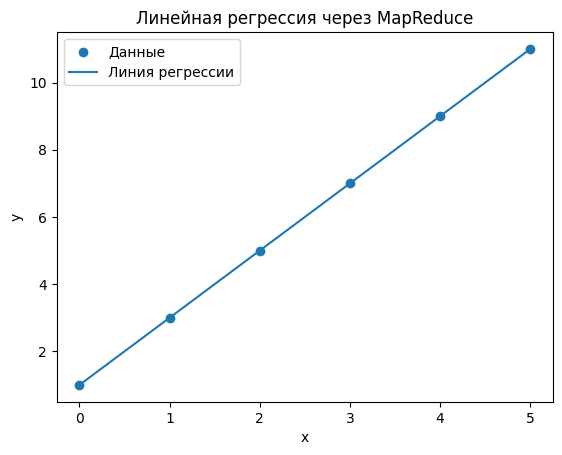

In [ ]:
import matplotlib.pyplot as plt

xs = [x for x, y in data_points]
ys = [y for x, y in data_points]

beta0 = stats["beta0"]
beta1 = stats["beta1"]

# Строим линию регрессии на том же интервале x
x_line = [min(xs), max(xs)]
y_line = [beta0 + beta1 * x for x in x_line]

plt.figure()
plt.scatter(xs, ys, label="Данные")
plt.plot(x_line, y_line, label="Линия регрессии")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Линейная регрессия через MapReduce")
plt.legend()
plt.show()
